In [156]:
import numpy as np 
import pandas as pd 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Fake-Real News Classification - (EDA)</h1>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">1. DATASET SIZE<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="profile">2. IMPORTING THE DATASET<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#3" role="tab" aria-controls="messages">3. DATA VISUALIZATION<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#4" role="tab" aria-controls="messages">4. DATA PROFILING<span class="badge badge-primary badge-pill">4</span></a>
   <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="messages">5. DATA PREPROCESSING<span class="badge badge-primary badge-pill">5</span></a>  
       <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="messages">6. (PRE-PROCESSED) DATA VISUALIZATION & STATISTICS <span class="badge badge-primary badge-pill">6</span></a>   
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#7" role="tab" aria-controls="messages">7. BAG-OF-WORDS MODEL<span class="badge badge-primary badge-pill">7</span></a>
</div>

<a id="1"></a> <br>
# DATASET SIZE

2 datasets - one each for fake news, true news with 20000 articles each.

<a id="2"></a> <br>
# IMPORTING THE DATASET

In [106]:
true = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

<a id="3"></a> <br>
# DATA VISUALIZATION

**Real data**

In [107]:
true.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

**Fake data**

In [108]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

**Original data dimension**

In [109]:
print('True',true.shape)
print('Fake',fake.shape)

True (21417, 4)
Fake (23481, 4)


**Combining dataset & Adding category dimension**

In [110]:
true['category'] = 'True'
fake['category'] = 'Fake'

**Tuned data dimension**

In [111]:
from tqdm import tqdm
def text_size(df):
    sizes = []
    for text in tqdm(df['text']):
        len_ = len(text.split())
        sizes.append(len_)
    return np.array(sizes)

fake_size = text_size(fake)
true_size = text_size(true)

print('True',true.shape)
print('Fake',fake.shape)

fake['len'] = fake_size
true['len'] = true_size

100%|██████████| 21417/21417 [00:00<00:00, 42535.80it/s]

True (21417, 5)
Fake (23481, 5)


<a id="4"></a> <br>
# DATA PROFILING

In [112]:
df = pd.concat([true,fake]) 

from pandas_profiling import ProfileReport
#Detailed data Analysis/Profiling
prof = ProfileReport(df)
prof.to_file(output_file='dataProfile.html')

**Real vs Fake frequency**

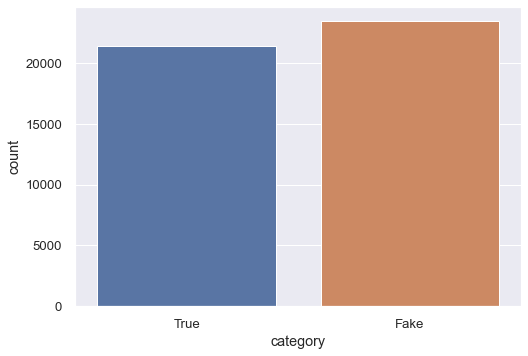

In [113]:
sns.set_style("darkgrid")
sns.countplot(df.category)

**Unified dataset(Real + Fake)**

In [114]:
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date category  len  
0  December 31, 2017      True  749  
1  December 29, 2017      True  624  
2  December 31, 2017      True  457  
3  December 30, 2017      True  376  
4  December 29, 2017      True  852

**Check for NAN, Missing data**

In [115]:
df.isna().sum() # Checking for nan Values

title       0
text        0
subject     0
date        0
category    0
len         0
dtype: int64

**Total title count**

In [116]:
df.title.count()

44898

**Total count by Subject**

In [117]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

<a id="5"></a> <br>
# DATA Preprocessing

**MERGING ALL THE TEXT DATA INTO 1 COLUMN 'text'**

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

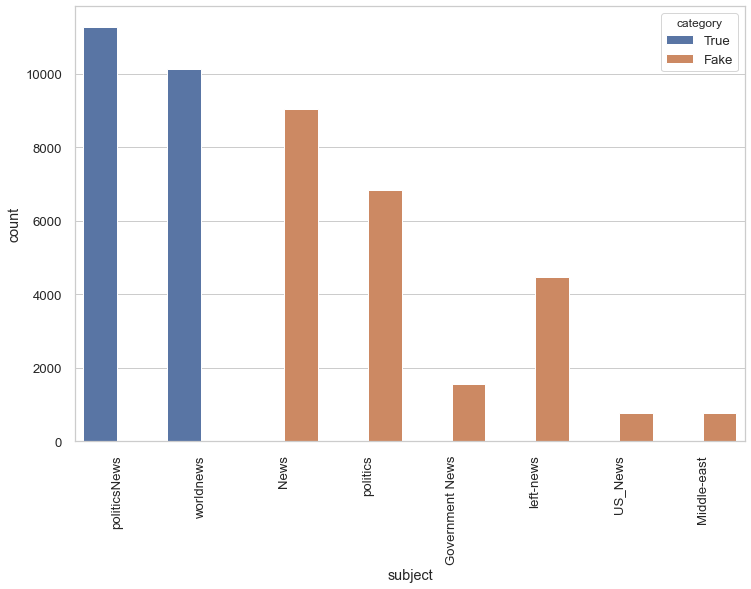

In [118]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN**

In [119]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**REMOVE STOPWORDS**


In [120]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**DATA CLEANING**

In [121]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def lemmatization(text):

    import nltk
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_word = list(set([wordnet_lemmatizer.lemmatize(x) for x in corpus]))
    return lemmatized_word

def stemming(text):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()

    #Stem
    stemmed_word = list(set([stemmer.stem(x) for x in corpus]))

    return stemmed_word

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    #text = lemmatization(text)
    
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

**Preprocessed data**

In [122]:
df['text']

0        WASHINGTON (Reuters) head conservative Republi...
1        WASHINGTON (Reuters) Transgender people allowe...
2        WASHINGTON (Reuters) special counsel investiga...
3        WASHINGTON (Reuters) Trump campaign adviser Ge...
4        SEATTLE/WASHINGTON (Reuters) President Donald ...
                               ...                        
23476    21st Century Wire says 21WIRE reported earlier...
23477    21st Century Wire says familiar theme. Wheneve...
23478    Patrick Henningsen 21st Century WireRemember O...
23479    21st Century Wire says Al Jazeera America go h...
23480    21st Century Wire says 21WIRE predicted new ye...
Name: text, Length: 44898, dtype: object

<a id="6"></a> <br>
# (PRE-PROCESSED) DATA VISUALIZATION & STATISTICS 

**Duplicate text**

In [123]:
from hashlib import sha256
from tqdm import tqdm
list_ = [ ]
for text in tqdm(df['text']):
    hash_ = sha256(text.encode('utf-8')).hexdigest()
    list_.append(hash_)
df['hash'] = list_
t = df.groupby(['hash']).size().reset_index(name='count')
duplicate = t[t['count']>1]
print('there are ',duplicate.shape[0], 'duplicate texts')

100%|██████████| 44898/44898 [00:00<00:00, 220623.53it/s]

there are  5306 duplicate texts


**Unique text**

In [124]:
from tqdm import tqdm
def unique_tokens(df):
    unique_tokens = set()
    for text in tqdm(df['text']):
        splited = text.split()
        for token in splited:
            unique_tokens.add(token)
    return unique_tokens

unique_tokens_fake = unique_tokens(fake)
unique_tokens_true = unique_tokens(true)

import plotly.express as px
twitter_users_fake_count = count_twitters_user(fake)
twitter_users_true_count = count_twitters_user(true)
fig = px.bar(y=[len(unique_tokens_fake), len(unique_tokens_true)], x=['Fake', 'True'], title='Unique tokens')
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

100%|██████████| 21417/21417 [00:01<00:00, 12653.18it/s]


**WORDCLOUD FOR REAL TEXT**

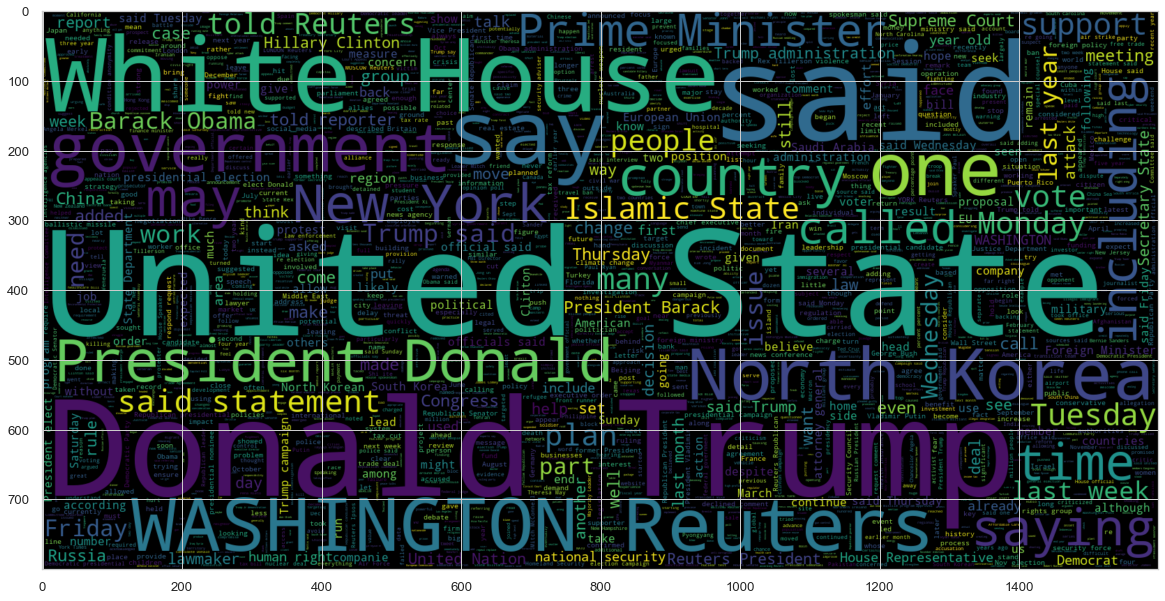

In [125]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 'True'].text))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR FAKE TEXT**

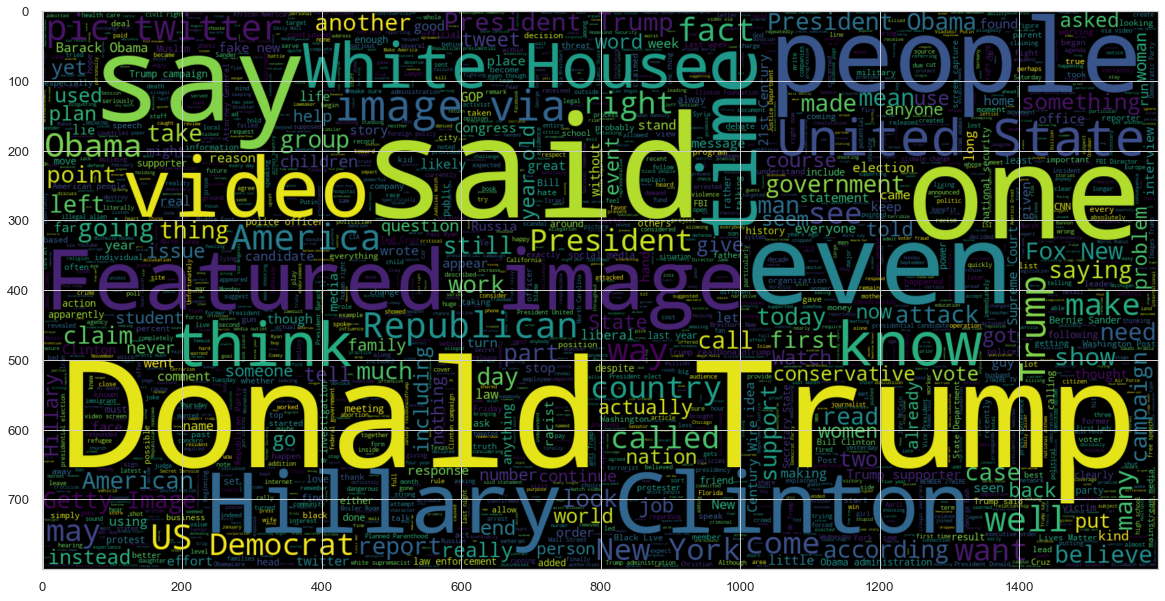

In [126]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 'Fake'].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in Real/ Fake news texts**

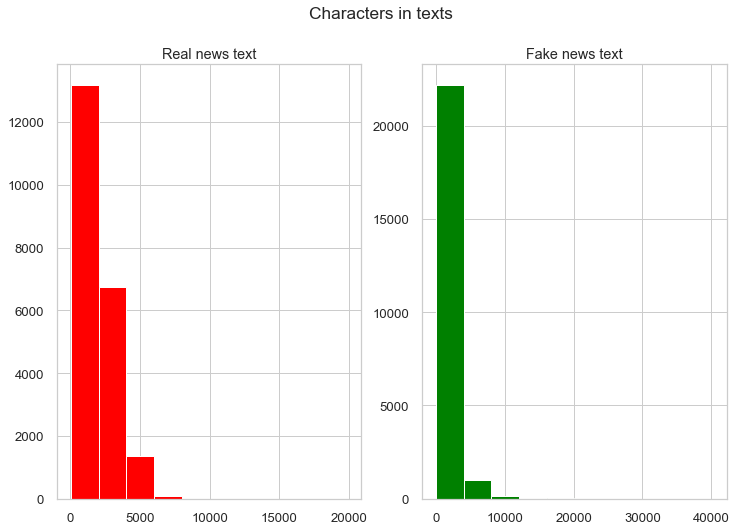

In [127]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']=='True']['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Real news text')

text_len=df[df['category']=='Fake']['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake news text')
fig.suptitle('Characters in texts')
plt.show()

> The distribution of fake and real news text seems to be different.

> 2500 characters in text is the most common in real news text category.

> 5000 characters in text are most common in fake news text category.

**Number of words in Real/ Fake news texts**

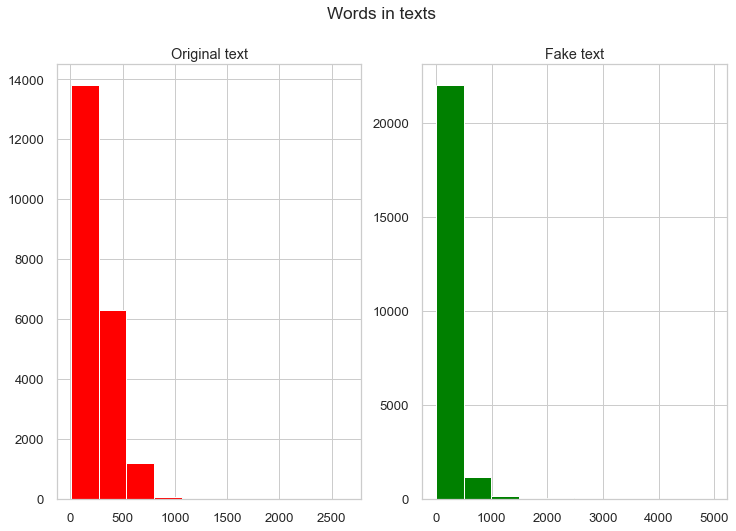

In [128]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']=='True']['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']=='Fake']['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in Real/ Fake text**

Text(0.5, 0.98, 'Average word length in each text')

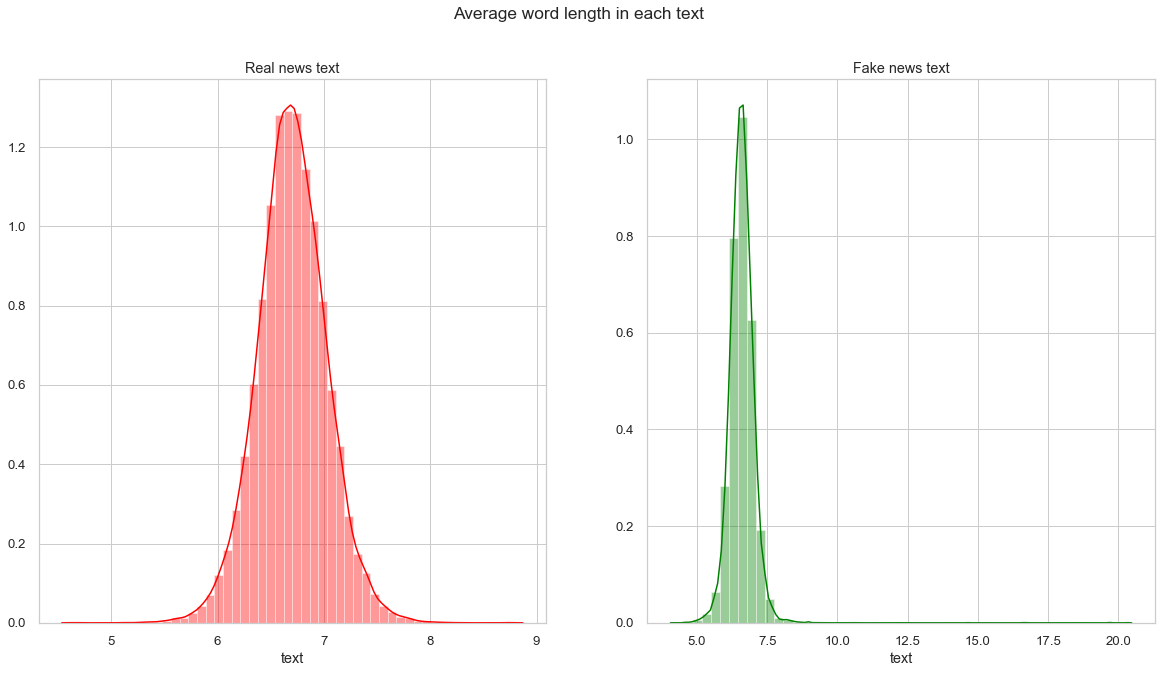

In [129]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']=='True']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Real news text')
word=df[df['category']=='Fake']['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake news text')
fig.suptitle('Average word length in each text')

In [130]:
fake_ = df[df['category']=='Fake']
true_ = df[df['category']=='True']
fig = go.Figure()
fig.add_trace(go.Box(y=list(fake_['len']), name='Fake',
                marker_color = 'indianred'))
fig.add_trace(go.Box(y=list(true_['len']), name = 'True',
                marker_color = 'lightseagreen'))

fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title': 'Box plot',
})
fig.show()

**TWITTER Hashtag machines**

In [145]:
#Count twitter hashtag mentions
import re
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count

import plotly.graph_objects as go

twitter_users_fake_count = count_twitters_user(fake)
twitter_users_true_count = count_twitters_user(true)
fig = go.Figure()
fig.add_trace(go.Bar(x=['Fake', 'True'],
    y=[twitter_users_fake_count, twitter_users_true_count],
    name='Twitter user name Pattern',
    marker_color='indianred')
)
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title': 'unique hashtags mentions in twitters',
})
fig.show()

**Preporcessed Corpus**

In [131]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words

corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

**MOST Common Words**

In [132]:
nltk.FreqDist(corpus).most_common(20)

[('Trump', 111503),
 ('said', 93162),
 ('would', 54613),
 ('U.S.', 50441),
 ('President', 33180),
 ('people', 33115),
 ('also', 30325),
 ('one', 29370),
 ('Donald', 27795),
 ('said.', 26194),
 ('Republican', 23921),
 ('could', 23637),
 ('told', 23213),
 ('Obama', 23201),
 ('House', 23188),
 ('United', 22861),
 ('Clinton', 22471),
 ('government', 21826),
 ('(Reuters)', 21247),
 ('like', 20535)]

**Words Only Once - HAPAXES**

In [133]:
from collections import Counter
def word_form_hapaxes(tokens):
    
    counts = Counter(tokens) # <1>
    hapaxes = [word for word in counts if counts[word] == 1] # <2>

    return hapaxes

words_once = word_form_hapaxes(corpus)
print('First 25 words that occur only once in the corpus:',words_once[1:25])



First 25 words that occur only once in the corpus: ['clean,”', 'DOD’s', 'currently-serving', 'Babb', 'GLAD,', 'entail.”', 'co-ordinated', 'tip-off:', 'MORE!”', '“Amazon', 'Post”', 'Ives,', 'GBH', 'Insights,', '(system)', '$1,175.90', 'Satish', 'Jindel,', 'ShipMatrix', '(FDX.N),', 'Jindel', 'journeys,', 'doorsteps.', 'Jindel.']


<a id="7"></a> <br>
# BAG-OF-WORDS MODEL

**Count Vectorizer**

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = df['text']
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'washington': 113850, 'reuters': 89968, 'head': 48857, 'conservative': 27001, 'republican': 89404, 'faction': 39438, 'congress': 26861, 'voted': 113090, 'month': 71079, 'huge': 51344, 'expansion': 38899, 'national': 73248, 'debt': 30577, 'pay': 80198, 'tax': 104116, 'cuts': 29347, 'called': 21282, 'fiscal': 41143, 'sunday': 102256, 'urged': 111134, 'budget': 20217, 'restraint': 89749, '2018': 3970, 'keeping': 58754, 'sharp': 95942, 'pivot': 82037, 'way': 114040, 'among': 10824, 'republicans': 89408, 'representative': 89337, 'mark': 66780, 'meadows': 68160, 'speaking': 99450, 'cbs': 22617, 'face': 39356, 'nation': 73247, 'drew': 34741, 'hard': 48260, 'line': 63576, 'federal': 40280, 'spending': 99576, 'lawmakers': 62171, 'bracing': 19102, 'battle': 15519, 'january': 55926, 'return': 89935, 'holidays': 50502, 'wednesday': 114271, 'begin': 16030, 'trying': 108338, 'pass': 79848, 'fight': 40804, 'likely': 63450, 'linked': 63623, 'issues': 55239, 'immigration': 52642, 'policy': 82701, 'eve

(44898, 118606)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**N-Gram Analysis**

In [148]:
def get_top_text_ngrams_CountVectorizer(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Unigram Analysis**

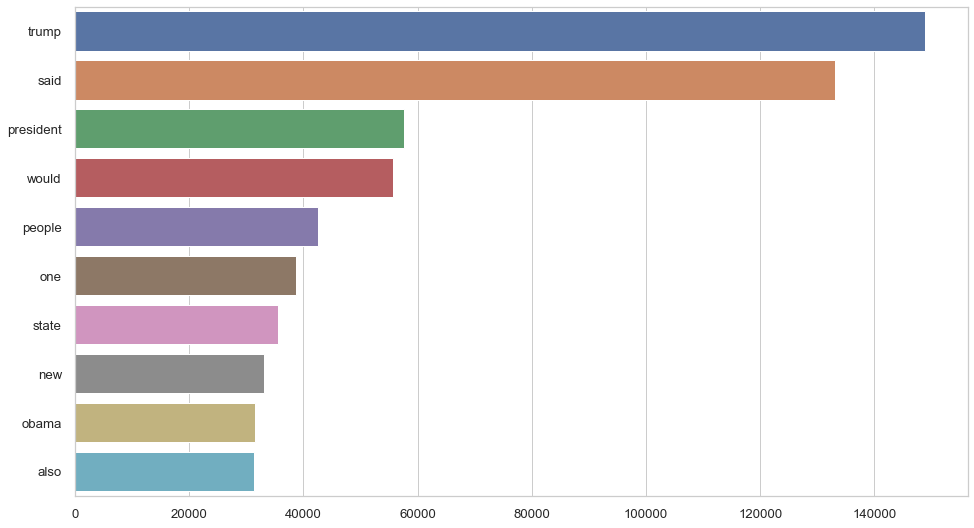

In [149]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams_CountVectorizer(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Bigram Analysis**

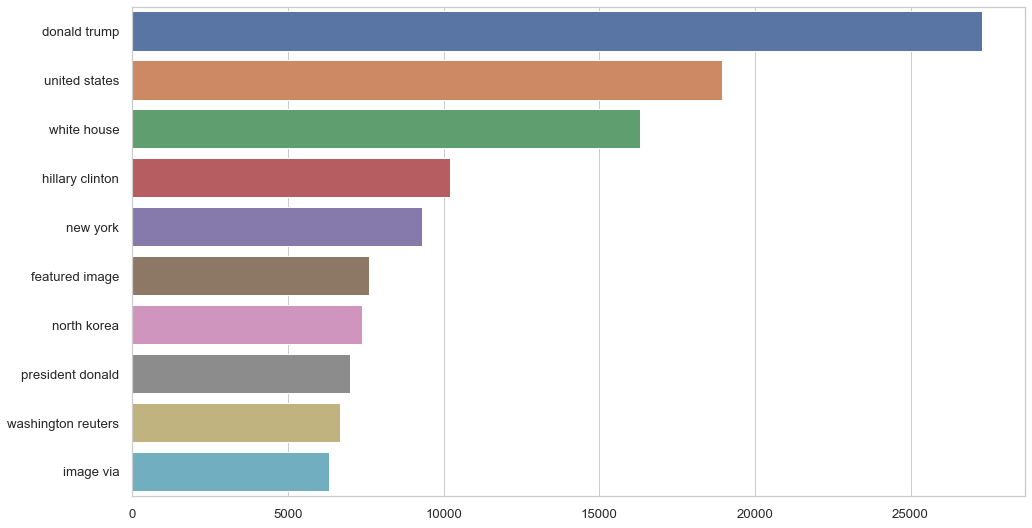

In [150]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams_CountVectorizer(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

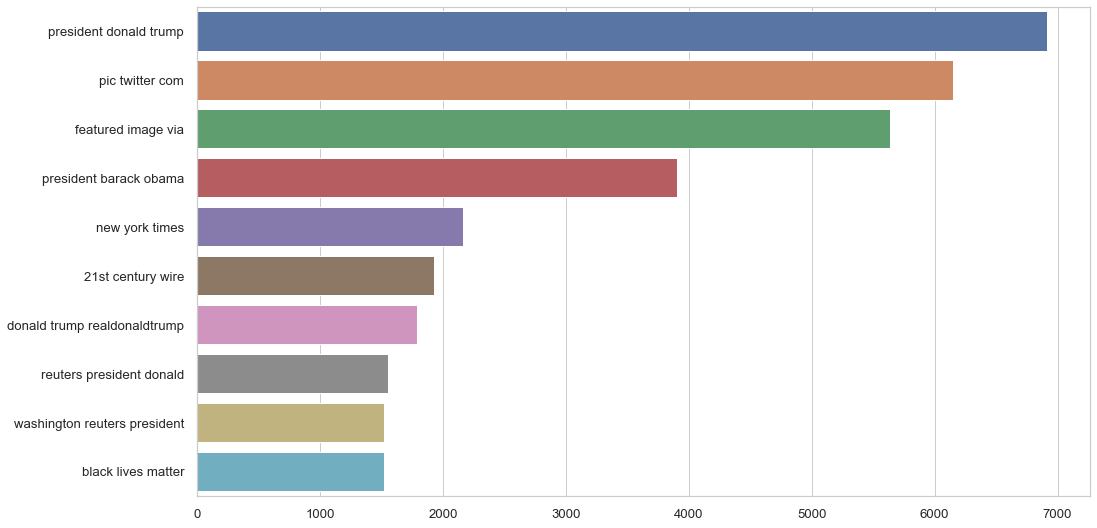

In [151]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams_CountVectorizer(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

**Tfidf Vectorizer**

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'washington': 113850, 'reuters': 89968, 'head': 48857, 'conservative': 27001, 'republican': 89404, 'faction': 39438, 'congress': 26861, 'voted': 113090, 'month': 71079, 'huge': 51344, 'expansion': 38899, 'national': 73248, 'debt': 30577, 'pay': 80198, 'tax': 104116, 'cuts': 29347, 'called': 21282, 'fiscal': 41143, 'sunday': 102256, 'urged': 111134, 'budget': 20217, 'restraint': 89749, '2018': 3970, 'keeping': 58754, 'sharp': 95942, 'pivot': 82037, 'way': 114040, 'among': 10824, 'republicans': 89408, 'representative': 89337, 'mark': 66780, 'meadows': 68160, 'speaking': 99450, 'cbs': 22617, 'face': 39356, 'nation': 73247, 'drew': 34741, 'hard': 48260, 'line': 63576, 'federal': 40280, 'spending': 99576, 'lawmakers': 62171, 'bracing': 19102, 'battle': 15519, 'january': 55926, 'return': 89935, 'holidays': 50502, 'wednesday': 114271, 'begin': 16030, 'trying': 108338, 'pass': 79848, 'fight': 40804, 'likely': 63450, 'linked': 63623, 'issues': 55239, 'immigration': 52642, 'policy': 82701, 'eve

AttributeError: 'Series' object has no attribute 'lower'

In [152]:
def get_top_text_ngrams_TfidfVectorizer(corpus, n, g):
    vec = TfidfVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

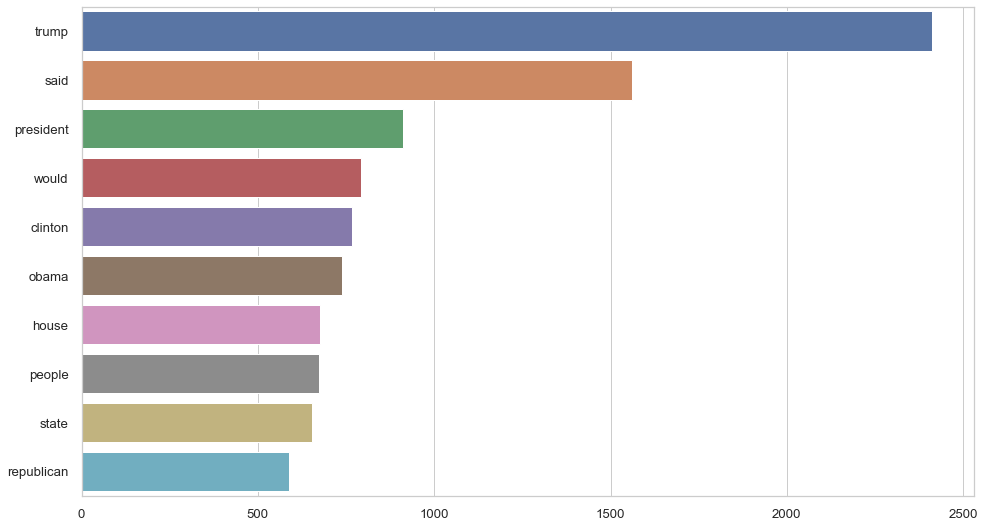

In [153]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams_TfidfVectorizer(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

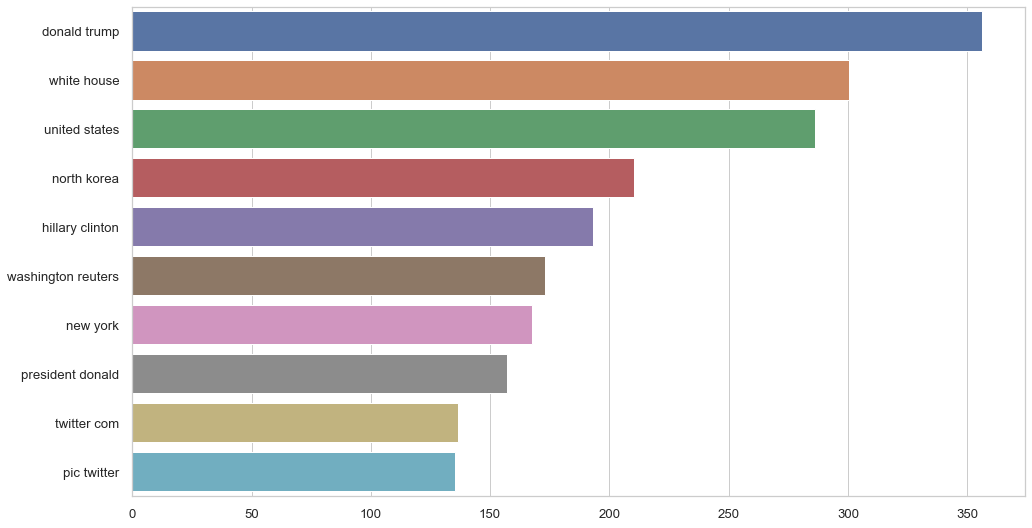

In [154]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams_TfidfVectorizer(df.text,10,2)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

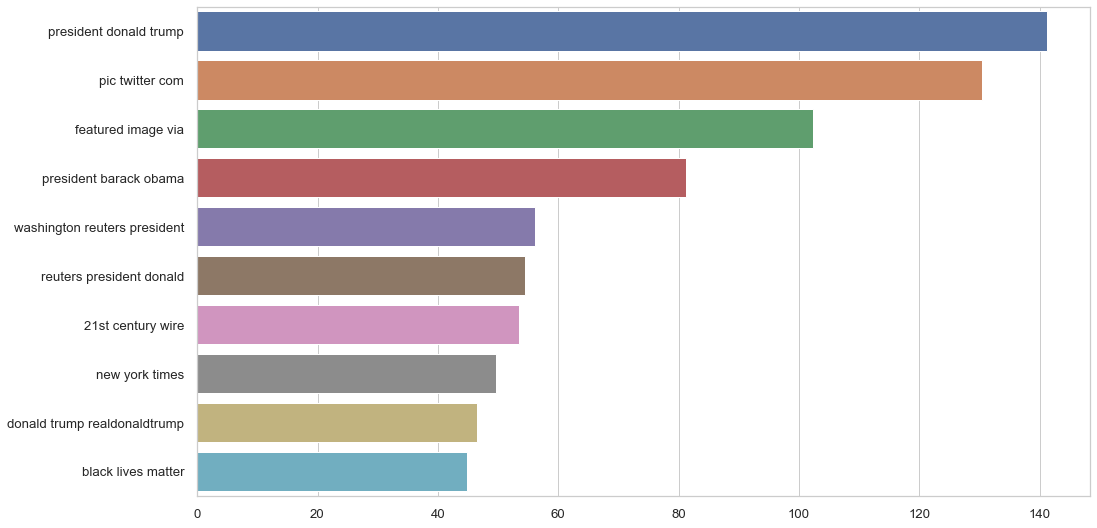

In [155]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams_TfidfVectorizer(df.text,10,3)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

TODO

MultinomialNB with hyper parameter
glove analysis